In [1]:
!pip install langchain langsmith langchain_community langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [2]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00


In [3]:
from typing import Annotated
from typing_extensions import TypedDict

In [4]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=c5d0ced7313fc29a43e3e7cbf53aa6a6c3aa3b9342552c04a52380971df03981
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=40a6e2df1c9ee8c4460d5d0f40a58f7d10bed83cc8605830e6066745a4248b65
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [5]:
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun

arxiv_warpper=ArxivAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_warpper)

wiki_wrapper=WikipediaAPIWrapper(top_k_results=1 , doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [6]:
wiki_tool.invoke("Who is shahrukh khan?")

'Page: Shah Rukh Khan filmography\nSummary: Shah Rukh Khan is an Indian actor, producer and television personality who works in Hindi films. He began his acting career by playing a soldier in the Doordarshan series Fauji (1988), a role that garnered him recognition and led to starring roles in more te'

In [7]:
arxiv_tool.invoke("Attention is all u need")

'Published: 2017-09-19\nTitle: Exploring Human-like Attention Supervision in Visual Question Answering\nAuthors: Tingting Qiao, Jianfeng Dong, Duanqing Xu\nSummary: Attention mechanisms have been widely applied in the Visual Question\nAnswering (VQA) task, as they help to focus on the area-of-interest of'

In [8]:
tools=[arxiv_tool,wiki_tool]

In [9]:
## LangGraph Application:
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list , add_messages]


In [10]:
from langgraph.graph import StateGraph , START , END

In [11]:
graph_builder=StateGraph(State)

In [15]:
import os

In [16]:
from google.colab import userdata
groq_api_key=userdata.get('Groq_API_Key')
os.environ['GROQ_API_KEY']=groq_api_key

LangChain_API_Key=userdata.get('LangChain_API_Key')
os.environ['LANGCHAIN_API_KEY']=LangChain_API_Key

In [17]:
from langchain_groq import ChatGroq
llm= ChatGroq(groq_api_key=groq_api_key , model = "gemma2-9b-it")

In [18]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7889f73209a0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7889f7323c40>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [19]:
llm_with_tools=llm.bind_tools(tools=tools)

In [20]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [21]:
from langgraph.prebuilt import ToolNode , tools_condition

In [22]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START , "chatbot")
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools" , tool_node)
graph_builder.add_conditional_edges("chatbot" , tools_condition)
graph_builder.add_edge("tools" , "chatbot")
graph_builder.add_edge("chatbot" , END)

In [23]:
graph=graph_builder.compile()

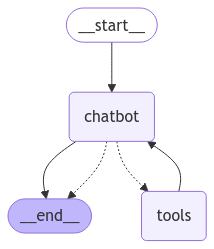

In [24]:
from IPython.display import Image , display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [26]:
user_input="Hi there! when did india got independence"
events=graph.stream(
    {"messages":[("user" , user_input)]} , stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! when did india got independence
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_09nv)
 Call ID: call_09nv
  Args:
    query: Independence of India
================================= Tool Message =================================
Name: wikipedia

Page: Indian independence movement
Summary: The Indian independence movement was a series of historic events in South Asia with the ultimate aim of ending British colonial rule. It lasted until 1947, when the Indian Independence Act 1947 was passed.
The first nationalistic movement for Indian indepe
================================== Ai Message ==================================

India gained independence on August 15, 1947.


## **ChatBot**

In [31]:
while True:
    # Prompt the user for input
    user_input = input("User: ")

    # Exit condition
    if user_input.lower() in ["quit", "q", "exit"]:
        print("Goodbye!")
        break

    # Create the stream of events from the LangGraph
    events = graph.stream(
        {"messages": [("user", user_input)]},
        stream_mode="values"
    )

    # Process each event in the stream
    for event in events:
        # Print the assistant's response in a user-friendly format
        if "messages" in event and event["messages"]:
            event["messages"][-1].pretty_print()


User: who was the first PM of India
================================ Human Message =================================

who was the first PM of India
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_qzg0)
 Call ID: call_qzg0
  Args:
    query: first Prime Minister of India
================================= Tool Message =================================
Name: wikipedia

Page: List of prime ministers of India
Summary: The prime minister of India is the chief executive of the Government of India and chair of the Union Council of Ministers. Although the president of India is the constitutional, nominal, and ceremonial head of state, in practice and ordinarily, the exe
================================== Ai Message ==================================

Jawaharlal Nehru
User: when did India won first cricket world cup
================================ Human Message =================================

when did India won first cricket worl